# About

### This script compare BCFL traning and local traning in EMNIST ByMerge dataset

https://www.nist.gov/itl/products-and-services/emnist-dataset

# Setup env

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch import optim
import pandas as pd
import sys


import time
import numpy as np
from concurrent import futures
import logging
import grpc
import argparse
import base64
import io
import matplotlib.pyplot as plt 
from tqdm import tqdm

In [2]:
def fullmodel2base64(model):
    buffer = io.BytesIO()
    torch.save(model, buffer)
    bg = buffer.getvalue()
    return base64.b64encode(bg).decode()

def base642fullmodel(modbase64):
    inputrpc = bytes(modbase64.encode())
    inputrpc_ = base64.b64decode(inputrpc)
    loadmodel = torch.load(io.BytesIO(inputrpc_))
    return loadmodel

In [3]:
class MNISTDataset(Dataset):
    """MNIST dataset"""
    
    def __init__(self, feature, target, transform=None):
        
        self.X = []
        self.Y = target
            
        if transform is not None:
            for i in range(len(feature)):
                self.X.append(transform(feature[i]))
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        
        return self.X[idx], self.Y[idx]

In [4]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5),
                                     nn.ReLU(inplace=True),
                                     nn.MaxPool2d(kernel_size=2),
                                     nn.Dropout(0.25),
                                     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
                                     nn.ReLU(inplace=True),
                                     nn.MaxPool2d(kernel_size=2, stride=2),
                                     nn.Dropout(0.25))
        
        self.classifier = nn.Sequential(nn.Linear(576, 256),
                                       nn.Dropout(0.5),
                                       nn.Linear(256, 47))

        
    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1) # flatten layer
        x = self.classifier(x)
        
        return x

In [5]:
def getdataloader(dset = './mnist_test.csv'):
    #print(dset)
    train = pd.read_csv(dset)

    train_labels = train['label'].values
    train_data = train.drop(labels = ['label'], axis = 1)
    train_data = train_data.values.reshape(-1,28, 28)
    
    featuresTrain = torch.from_numpy(train_data)
    targetsTrain = torch.from_numpy(train_labels)
    
    data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.ToTensor()])

    train_set = MNISTDataset(featuresTrain.float(), targetsTrain, transform=data_transform)
    
    trainloader = torch.utils.data.DataLoader(train_set, batch_size = 8192, shuffle = True, num_workers=8)
    return trainloader

In [6]:
def read_bcfl_model(txtpath,inipfs=False):
    file = open(txtpath,'r')
    context = file.readline()
    file.close()
    lcontext = context.split(',')
    models = []
    if not inipfs:
        for i in lcontext:
            models.append(base642fullmodel(i))
    else:
        print("Download...")
        import ipfshttpclient
        client = ipfshttpclient.connect("/ip4/140.113.164.150/tcp/5001/")
        for i in lcontext:
            m = client.cat(i).decode()
            models.append(base642fullmodel(m))
    return models

In [7]:
def acc_plot(models, dataloder, device="cpu"):
    
    accd = []
    for m in tqdm(models):
        ans = np.array([])
        res = np.array([])
        model = m.to(device)
        
        model.eval()
        for data, target in dataloder:
            #data = data.view(data.size(0),-1)

            output = model(data.float().to(device))

            _, preds_tensor = torch.max(output, 1)
            preds = np.squeeze(preds_tensor.cpu().numpy())
            ans = np.append(ans, np.array(target))
            res = np.append(res, np.array(preds))

        #getit = 0
        #for i in range(len(ans)):
        #    if ans[i]==res[i]:
        #        getit+=1
        #acc = getit/len(ans)
        acc = (ans==res).sum()/len(ans)
        accd.append(acc)
        
    return accd

In [29]:
# Create first base-model
# fullmodel2base64(Model())

# BCFL result

In [14]:
dev=torch.device("cuda")
test_dloader = getdataloader('./emnist/emnist_test.csv')

In [ ]:
bcfl_acc = acc_plot(read_bcfl_model('./emnist/100_round_emodel_id_0.txt',inipfs=True), test_dloader, device=dev)

Download...


/opt/conda/lib/python3.6/site-packages/torch/serialization.py:419: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
 85%|████████▌ | 86/101 [04:07<00:43,  2.89s/it]

In [ ]:
plt.grid(True)
plt.ylabel("Accuracy")
plt.xlabel("Round")
plt.plot(bcfl_acc)

# Local training

In [8]:
dev=torch.device("cuda")

In [9]:
dloader = getdataloader('./emnist/emnist_train_all.csv')
test_dloader = getdataloader('./emnist/emnist_test.csv')

In [10]:
model = Model()

optimizer = optim.RMSprop(model.parameters(), lr=0.001)

loss_function = nn.CrossEntropyLoss()

In [11]:
model.cuda()
model.train()

models = []

for i in tqdm(range(100)):
    #print("E : ", i)
    running_loss = 0
    for data, target in dloader:
        
        data = data.cuda()
        target = target.cuda()
        optimizer.zero_grad()
        #data = data.view(data.size(0),-1)

        output = model(data.float())

        loss = loss_function(output, target)

        loss.backward()

        optimizer.step()
        
        running_loss += loss.item()
    models.append(model)
    #print("loss: ",running_loss/len(dloader))

100%|██████████| 100/100 [27:08<00:00, 16.28s/it]


In [12]:
local_acc = acc_plot(models, test_dloader,device=dev)

100%|██████████| 100/100 [06:43<00:00,  4.04s/it]


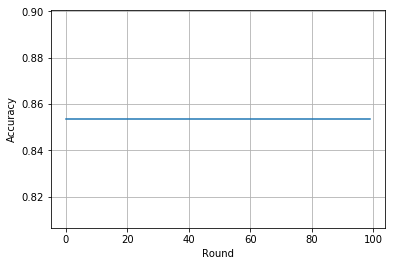

In [13]:
plt.grid(True)
plt.ylabel("Accuracy")
plt.xlabel("Round")
plt.plot(local_acc)

# Compare

In [ ]:
plt.grid(True)
plt.ylabel("Accuracy")
plt.xlabel("Round")
#plt.plot(range(10), bcfl_acc[:10], range(10), local_acc[:10])
plt.plot(range(100), bcfl_acc[:100], color='red', label='BCFL')
plt.plot(range(100), local_acc[:100], color='green', label='LOCAL')
plt.legend()

plt.show()